<a href="https://colab.research.google.com/github/christine127/Portfolio_Recommendation_Project/blob/main/%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install mlxtend --upgrade

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import mlxtend

In [3]:
path ='/content/drive/MyDrive/소회의실 프로젝트/전처리_완료/최종/'
file = pd.read_csv(path + '원본_210728.csv', encoding ='cp949')
customer_info = pd.read_csv(path+'customer_info_5가지_샘플제외.csv' )

sample_file = pd.read_csv(path+'원본_sample100.csv' , encoding='cp949')
sample_info = pd.read_csv(path+'customer_info_5가지_샘플.csv' )


In [4]:
# 거래횟수 상위 10 종목 제외

stock = file.groupby('상품명')['상품명'].count().sort_values(ascending = False)[:10]
stock= pd.DataFrame(stock).rename(columns = {'상품명':'count'}).reset_index()

file = file.loc[~file['상품명'].isin(stock['상품명'])]
sample_file = sample_file.loc[~sample_file['상품명'].isin(stock['상품명'])]

In [5]:
cluster_dict = customer_info.set_index('고객구분코드')['cluster'].to_dict()
file['cluster'] = file['고객구분코드'].map(cluster_dict).astype(str)

cluster_dict = sample_info.set_index('고객구분코드')['cluster'].to_dict()
sample_file['cluster'] = sample_file['고객구분코드'].map(cluster_dict).astype(str)

In [6]:
file['code'] = file['상품번호'].str[-6:]
sample_file['code'] = sample_file['상품번호'].str[-6:]


In [7]:
file= file.dropna()
customer_info =customer_info.dropna()
sample_info =sample_info.dropna()

In [8]:
## file
retain_df = pd.DataFrame(file.groupby(['고객구분코드','상품명','매도매수구분코드'])['총체결수량'].sum()).unstack('매도매수구분코드').fillna(0)
retain_df['보유개수']= retain_df[('총체결수량',2)]-retain_df[('총체결수량',1)]
retain_df['보유개수'] = np.where(retain_df['보유개수']<0, 0,retain_df['보유개수'])
retain_stock_list = retain_df['보유개수'].reset_index().groupby(['고객구분코드'])['상품명'].apply(list)
customer_info.set_index('고객구분코드', inplace= True )
customer_info = customer_info.join(retain_stock_list, how = 'left')

##sample_file
retain_df_sample = pd.DataFrame(sample_file.groupby(['고객구분코드','상품명','매도매수구분코드'])['총체결수량'].sum()).unstack('매도매수구분코드').fillna(0)
retain_df_sample['보유개수']= retain_df_sample[('총체결수량',2)]-retain_df_sample[('총체결수량',1)]
retain_df_sample['보유개수'] = np.where(retain_df_sample['보유개수']<0, 0,retain_df_sample['보유개수'])
retain_stock_list_sample = retain_df_sample['보유개수'].reset_index().groupby(['고객구분코드'])['상품명'].apply(list)
sample_info.set_index('고객구분코드', inplace= True )
sample_info = sample_info.join(retain_stock_list_sample, how = 'left')


In [9]:
# customer_info.drop(['상품명'], axis=1, inplace= True)
# sample_info.drop(['상품명'], axis=1, inplace= True)

In [10]:
customer_info = customer_info.dropna()
sample_info = sample_info.dropna()

## FP-Growth 전처리: 
[[cluster, 종목명],[cluster, 종목명],[cluster, 종목명]] 

In [11]:
# lst2 = list(file.groupby('고객구분코드')['code'].unique().agg(list) + file.groupby('고객구분코드')['cluster'].unique().agg(list))
# lst_whole = list(customer_info['상품명']+ customer_info['cluster'].astype(str).apply(list))
lst_whole = customer_info['상품명']
lst_sample = sample_info['상품명']

In [12]:
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_ary_whole = te.fit(lst_whole).transform(lst_whole)
df_whole = pd.DataFrame(te_ary_whole, columns=te.columns_)

te_ary_sample = te.fit(lst_sample).transform(lst_sample)
df_sample = pd.DataFrame(te_ary_sample, columns=te.columns_)


# 전체

## binary

In [13]:
v_whole = df_whole.astype(int).T.dot(df_whole.astype(int))
v_whole = v_whole/len(df_whole)

In [26]:
itemsets = v_whole.unstack().index.to_list()
support = v_whole.unstack().values
support_lst = pd.DataFrame({'support':support,'itemsets':itemsets})


In [27]:
idx = support_lst.loc[support_lst['itemsets'].isin((list(zip(v_whole.index,v_whole.columns)))),'itemsets'].index
support_lst.loc[support_lst['itemsets'].isin((list(zip(v_whole.index,v_whole.columns)))),'itemsets'] =pd.Series(list(zip(v_whole.index)), index=idx)
support_lst

,support,itemsets
0,0.000784,"((주)마이크로컨텍솔루션,)"
1,0.000000,"((주)마이크로컨텍솔루션, (주)스카이이앤엠)"
2,0.000000,"((주)마이크로컨텍솔루션, (주)포스코엠텍)"
3,0.000000,"((주)마이크로컨텍솔루션, AJ네트웍스보통주)"
4,0.000041,"((주)마이크로컨텍솔루션, AK홀딩스보통주)"
...,...,...
3837676,0.000000,"(힘스, 흥국화재해상보험2우선주(신형))"
3837677,0.000041,"(힘스, 흥국화재해상보험보통주)"
3837678,0.000000,"(힘스, 흥아해운보통주)"
3837679,0.000000,"(힘스, 희림종합건축사사무소)"


In [28]:
# from mlxtend.frequent_patterns import association_rules, fpgrowth
rules = association_rules(support_lst, metric='lift',min_threshold = 1)
rules[['antecedents','consequents']] = rules[['antecedents','consequents']].applymap(lambda x: tuple(x))


KeyboardInterrupt: ignored

## 보유수량

In [41]:
unstack_df = retain_df['보유개수'].unstack().fillna(0)
unstack_df = unstack_df.loc[unstack_df.index.isin(customer_info.index)].reset_index(drop= True)
product_mtx = unstack_df.T.dot(df_whole.astype(int))
product_mtx = product_mtx / len(df_whole)

In [15]:
itemsets = product_mtx.unstack().index.to_list()
support = product_mtx.unstack().values
support_lst = pd.DataFrame({'support':support,'itemsets':itemsets})
support_lst

,support,itemsets
0,0.084984,"((주)마이크로컨텍솔루션, (주)마이크로컨텍솔루션)"
1,0.000000,"((주)마이크로컨텍솔루션, (주)스카이이앤엠)"
2,0.000000,"((주)마이크로컨텍솔루션, (주)포스코엠텍)"
3,0.000000,"((주)마이크로컨텍솔루션, AJ네트웍스보통주)"
4,0.000165,"((주)마이크로컨텍솔루션, AK홀딩스보통주)"
...,...,...
3837676,0.000000,"(힘스, 흥국화재해상보험2우선주(신형))"
3837677,0.000000,"(힘스, 흥국화재해상보험보통주)"
3837678,0.000000,"(힘스, 흥아해운보통주)"
3837679,0.000000,"(힘스, 희림종합건축사사무소)"


In [16]:
idx = support_lst.loc[support_lst['itemsets'].isin((list(zip(product_mtx.index,product_mtx.columns)))),'itemsets'].index
support_lst.loc[support_lst['itemsets'].isin((list(zip(product_mtx.index,product_mtx.columns)))),'itemsets'] =pd.Series(list(zip(product_mtx.index)), index=idx)
support_lst

,support,itemsets
0,0.084984,"((주)마이크로컨텍솔루션,)"
1,0.000000,"((주)마이크로컨텍솔루션, (주)스카이이앤엠)"
2,0.000000,"((주)마이크로컨텍솔루션, (주)포스코엠텍)"
3,0.000000,"((주)마이크로컨텍솔루션, AJ네트웍스보통주)"
4,0.000165,"((주)마이크로컨텍솔루션, AK홀딩스보통주)"
...,...,...
3837676,0.000000,"(힘스, 흥국화재해상보험2우선주(신형))"
3837677,0.000000,"(힘스, 흥국화재해상보험보통주)"
3837678,0.000000,"(힘스, 흥아해운보통주)"
3837679,0.000000,"(힘스, 희림종합건축사사무소)"


In [17]:
from mlxtend.frequent_patterns import association_rules, fpgrowth
rules = association_rules(support_lst, metric='lift',min_threshold = 1)
rules[['antecedents','consequents']] = rules[['antecedents','consequents']].applymap(lambda x: tuple(x))


/usr/local/lib/python3.7/dist-packages/mlxtend/frequent_patterns/association_rules.py:106: RuntimeWarning: invalid value encountered in double_scalars
  "lift": lambda sAC, sA, sC: metric_dict["confidence"](sAC, sA, sC)/sC,
/usr/local/lib/python3.7/dist-packages/mlxtend/frequent_patterns/association_rules.py:105: RuntimeWarning: invalid value encountered in double_scalars
  "confidence": lambda sAC, sA, _: sAC/sA,
/usr/local/lib/python3.7/dist-packages/mlxtend/frequent_patterns/association_rules.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  "confidence": lambda sAC, sA, _: sAC/sA,
/usr/local/lib/python3.7/dist-packages/mlxtend/frequent_patterns/association_rules.py:106: RuntimeWarning: divide by zero encountered in double_scalars
  "lift": lambda sAC, sA, sC: metric_dict["confidence"](sAC, sA, sC)/sC,
/usr/local/lib/python3.7/dist-packages/mlxtend/frequent_patterns/association_rules.py:105: RuntimeWarning: divide by zero encountered in true_divide
  "confidence

#### 전체 대상 지지도 1%

In [ ]:
from mlxtend.frequent_patterns import association_rules, fpgrowth
fpwhole = fpgrowth(df_whole, 0.01, True)

In [ ]:
pd.set_option('display.max_rows',1000)
fpwhole[fpwhole['itemsets'].apply(lambda x: len(x))>1].sort_values('support', ascending=False)

#### 전체 대상 지지도 0.03%이상인 상품 조합으로 신뢰도 50%이상인 것 뽑은 리스트

In [ ]:
# from pyspark.ml.fpm import FPGrowth

# df = spark.createDataFrame([
#     (0, [1, 2, 5]),
#     (1, [1, 2, 3, 5]),
#     (2, [1, 2])
# ], ["id", "items"])

# fpGrowth = FPGrowth(itemsCol="items", minSupport=0.5, minConfidence=0.6)
# model = fpGrowth.fit(df)

# # Display frequent itemsets.
# model.freqItemsets.show()

# # Display generated association rules.
# model.associationRules.show()

# # transform examines the input items against all the association rules and summarize the
# # consequents as prediction
# model.transform(df).show()

In [ ]:
from mlxtend.frequent_patterns import association_rules, fpgrowth
# fp_whole = fpgrowth(df_whole, 0.0003, True)
rules = association_rules(fpwhole, metric='lift',min_threshold = 1)
rules[['antecedents','consequents']] = rules[['antecedents','consequents']].applymap(lambda x: tuple(x))

# fp_whole.sort_values('support',ascending =False)
# fp_whole.loc[fp_whole.itemsets.apply(lambda x: len(x))>1,:].reset_index(drop=True).sort_values('support')

#### sample_info
8000명 이외의 사람의 상품목록 뽑은 후 그 사람이 가진 상품과 신뢰도가 높은 상품 뽑아내기

In [21]:
#샘플 고객의 상품목록에서 부분집합 추출

from itertools import combinations

a=sample_info.iloc[0,-1]
result=[]

for i in range(0,len(a)+1):
    c=combinations(a,i)
    result.extend(c)

# print(result)

In [22]:
# 0번째 고객은 모두 삼성전자 보통주만 추천 
rules.loc[rules.antecedents.isin(result),:].sort_values('lift', ascending =False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
51947,"(빙그레보통주,)","(샘표식품보통주,)",0.030337,0.001403,0.004458,0.146939,104.706843,4.415080e-03,1.170604
52017,"(빙그레보통주,)","(태광,)",0.030337,0.003219,0.004458,0.146939,45.641444,4.359986e-03,1.168475
52019,"(빙그레보통주,)","(팅크웨어,)",0.030337,0.007595,0.004458,0.146939,19.348004,4.227259e-03,1.163346
51991,"(빙그레보통주,)","(오뚜기보통주,)",0.030337,0.008255,0.004540,0.149660,18.129796,4.289774e-03,1.166292
1939,"(빙그레보통주,)","(GS1우선주,)",0.030337,0.007677,0.003921,0.129252,16.836076,3.688185e-03,1.139621
...,...,...,...,...,...,...,...,...,...
4982,"(LG화학보통주,)","(컴투스,)",0.340887,0.013497,0.004664,0.013682,1.013726,6.315375e-05,1.000188
4229,"(LG화학보통주,)","(KR모터스보통주,)",0.340887,1.715494,0.590226,1.731444,1.009298,5.437146e-03,inf
5331,"(NAVER보통주,)","(삼천리보통주,)",0.233903,0.002105,0.000495,0.002118,1.005948,2.928470e-06,1.000013
52047,"(빙그레보통주,)","(현대모비스보통주,)",0.030337,0.146071,0.004458,0.146939,1.005943,2.633578e-05,1.001018


# 군집별 분석
- 군집 간 인원 수 차이가 크기 때문에 신뢰도를 일정하게 설정하게 되면 나오는 빈발집합 수가 차이가 많이 남

### 0번 군집

In [21]:
customer_info =customer_info.reset_index()

In [25]:
cluster_0 = customer_info.loc[customer_info['cluster']==0].index
df0 = df_whole.loc[df_whole.index.isin(cluster_0)].reset_index(drop= True)

In [53]:
id_0 = customer_info.loc[customer_info['cluster']==0,'고객구분코드']
unstack_df = retain_df['보유개수'].unstack().fillna(0)
unstack_df = unstack_df.loc[unstack_df.index.isin(id_0)].reset_index(drop= True)
product_mtx = unstack_df.T.dot(df0.astype(int))
product_mtx = product_mtx / unstack_df.sum().sum()

In [54]:
itemsets = product_mtx.unstack().index.to_list()
support = product_mtx.unstack().values
support_lst = pd.DataFrame({'support':support,'itemsets':itemsets})
support_lst

,support,itemsets
0,0.00,"((주)마이크로컨텍솔루션, (주)마이크로컨텍솔루션)"
1,0.00,"((주)마이크로컨텍솔루션, (주)스카이이앤엠)"
2,0.00,"((주)마이크로컨텍솔루션, (주)포스코엠텍)"
3,0.00,"((주)마이크로컨텍솔루션, AJ네트웍스보통주)"
4,0.00,"((주)마이크로컨텍솔루션, AK홀딩스보통주)"
...,...,...
3837676,0.00,"(힘스, 흥국화재해상보험2우선주(신형))"
3837677,0.00,"(힘스, 흥국화재해상보험보통주)"
3837678,0.00,"(힘스, 흥아해운보통주)"
3837679,0.00,"(힘스, 희림종합건축사사무소)"


In [55]:
idx = support_lst.loc[support_lst['itemsets'].isin((list(zip(product_mtx.index,product_mtx.columns)))),'itemsets'].index
support_lst.loc[support_lst['itemsets'].isin((list(zip(product_mtx.index,product_mtx.columns)))),'itemsets'] =pd.Series(list(zip(product_mtx.index)), index=idx)
support_lst

,support,itemsets
0,0.00,"((주)마이크로컨텍솔루션,)"
1,0.00,"((주)마이크로컨텍솔루션, (주)스카이이앤엠)"
2,0.00,"((주)마이크로컨텍솔루션, (주)포스코엠텍)"
3,0.00,"((주)마이크로컨텍솔루션, AJ네트웍스보통주)"
4,0.00,"((주)마이크로컨텍솔루션, AK홀딩스보통주)"
...,...,...
3837676,0.00,"(힘스, 흥국화재해상보험2우선주(신형))"
3837677,0.00,"(힘스, 흥국화재해상보험보통주)"
3837678,0.00,"(힘스, 흥아해운보통주)"
3837679,0.00,"(힘스, 희림종합건축사사무소)"


In [56]:
import pandas as pd
pd.options.display.float_format = '{:.6f}'.format
support_lst.loc[~support_lst.index.isin(idx),'support'].describe()

count   3835722.000000
mean          0.000003
std           0.000052
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.009063
Name: support, dtype: float64

In [59]:
support_lst.loc[support_lst['itemsets'].apply(lambda x: len(x)) > 1].sort_values('support', ascending =False)
# support_lst.loc[~support_lst.index.isin(idx),]

,support,itemsets
1080717,0.009063,"(바이오니아, 이화전기공업)"
377436,0.007361,"(남선알미늄보통주, 이화전기공업)"
968443,0.006751,"(메가엠디, 서울식품공업보통주)"
1637073,0.006669,"(써니전자보통주, 이화전기공업)"
3789403,0.006110,"(후성 보통주, 서울식품공업보통주)"
...,...,...
1331317,0.000000,"(상신이디피, 와이엠티)"
1331318,0.000000,"(상신이디피, 와이오엠)"
1331319,0.000000,"(상신이디피, 와이제이엠게임즈)"
1331320,0.000000,"(상신이디피, 와이지-원)"


In [60]:
from mlxtend.frequent_patterns import association_rules, fpgrowth
rules_0 = association_rules(support_lst, metric='lift',min_threshold = 1)
rules_0[['antecedents','consequents']] = rules_0[['antecedents','consequents']].applymap(lambda x: tuple(x))
rules_0 = rules_0.loc[rules_0['lift']!=np.inf].reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/mlxtend/frequent_patterns/association_rules.py:106: RuntimeWarning: invalid value encountered in double_scalars
  "lift": lambda sAC, sA, sC: metric_dict["confidence"](sAC, sA, sC)/sC,
/usr/local/lib/python3.7/dist-packages/mlxtend/frequent_patterns/association_rules.py:105: RuntimeWarning: invalid value encountered in double_scalars
  "confidence": lambda sAC, sA, _: sAC/sA,
/usr/local/lib/python3.7/dist-packages/mlxtend/frequent_patterns/association_rules.py:106: RuntimeWarning: divide by zero encountered in double_scalars
  "lift": lambda sAC, sA, sC: metric_dict["confidence"](sAC, sA, sC)/sC,
/usr/local/lib/python3.7/dist-packages/mlxtend/frequent_patterns/association_rules.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  "confidence": lambda sAC, sA, _: sAC/sA,
/usr/local/lib/python3.7/dist-packages/mlxtend/frequent_patterns/association_rules.py:105: RuntimeWarning: divide by zero encountered in true_divide
  "confidence

In [63]:
rules_0.sort_values(['support','lift','confidence'], ascending=False)[:20]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
153581,"(서울식품공업보통주,)","(후성 보통주,)",0.030398,0.001183,0.006110,0.200989,169.881773,0.006074,1.250067
153580,"(후성 보통주,)","(서울식품공업보통주,)",0.001183,0.030398,0.006110,5.164115,169.881773,0.006074,inf
228086,"(진원생명과학보통주,)","(이화전기공업,)",0.010337,0.017708,0.005851,0.566033,31.964070,0.005668,2.263517
228087,"(이화전기공업,)","(진원생명과학보통주,)",0.017708,0.010337,0.005851,0.330403,31.964070,0.005668,1.477999
228127,"(이화전기공업,)","(코미팜,)",0.017708,0.002729,0.005622,0.317471,116.327429,0.005574,1.461141
228126,"(코미팜,)","(이화전기공업,)",0.002729,0.017708,0.005622,2.059975,116.327429,0.005574,inf
152994,"(에이아이비트,)","(서울식품공업보통주,)",0.001257,0.030398,0.005306,4.221047,138.858035,0.005267,inf
152995,"(서울식품공업보통주,)","(에이아이비트,)",0.030398,0.001257,0.005306,0.174535,138.858035,0.005267,1.209915
153518,"(한창제지보통주,)","(서울식품공업보통주,)",0.006766,0.030398,0.005109,0.755108,24.840462,0.004903,3.959296
153519,"(서울식품공업보통주,)","(한창제지보통주,)",0.030398,0.006766,0.005109,0.168072,24.840462,0.004903,1.193894


#### sample_info
8000명 이외의 사람의 상품목록 뽑은 후 그 사람이 가진 상품과 신뢰도가 높은 상품 뽑아내기

In [68]:
#샘플 고객의 상품목록에서 부분집합 추출

from itertools import combinations

cluster_prod=sample_info.loc[sample_info['cluster']==0,'상품명']
print(len(cluster_prod))

a = cluster_prod[0]
result=[]

for i in range(0,len(a)+1):
    c=combinations(a,i)
    result.extend(c)

print(result)

27
[(), ('녹십자보통주',), ('디피씨보통주',), ('일양약품보통주',), ('초록뱀미디어',), ('후성 보통주',), ('녹십자보통주', '디피씨보통주'), ('녹십자보통주', '일양약품보통주'), ('녹십자보통주', '초록뱀미디어'), ('녹십자보통주', '후성 보통주'), ('디피씨보통주', '일양약품보통주'), ('디피씨보통주', '초록뱀미디어'), ('디피씨보통주', '후성 보통주'), ('일양약품보통주', '초록뱀미디어'), ('일양약품보통주', '후성 보통주'), ('초록뱀미디어', '후성 보통주'), ('녹십자보통주', '디피씨보통주', '일양약품보통주'), ('녹십자보통주', '디피씨보통주', '초록뱀미디어'), ('녹십자보통주', '디피씨보통주', '후성 보통주'), ('녹십자보통주', '일양약품보통주', '초록뱀미디어'), ('녹십자보통주', '일양약품보통주', '후성 보통주'), ('녹십자보통주', '초록뱀미디어', '후성 보통주'), ('디피씨보통주', '일양약품보통주', '초록뱀미디어'), ('디피씨보통주', '일양약품보통주', '후성 보통주'), ('디피씨보통주', '초록뱀미디어', '후성 보통주'), ('일양약품보통주', '초록뱀미디어', '후성 보통주'), ('녹십자보통주', '디피씨보통주', '일양약품보통주', '초록뱀미디어'), ('녹십자보통주', '디피씨보통주', '일양약품보통주', '후성 보통주'), ('녹십자보통주', '디피씨보통주', '초록뱀미디어', '후성 보통주'), ('녹십자보통주', '일양약품보통주', '초록뱀미디어', '후성 보통주'), ('디피씨보통주', '일양약품보통주', '초록뱀미디어', '후성 보통주'), ('녹십자보통주', '디피씨보통주', '일양약품보통주', '초록뱀미디어', '후성 보통주')]


In [72]:
rules_0.loc[rules_0.antecedents.isin(result),:].sort_values(['support','lift','confidence'], ascending =False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
153580,"(후성 보통주,)","(서울식품공업보통주,)",0.001183,0.030398,0.006110,5.164115,169.881773,0.006074,inf
153269,"(초록뱀미디어,)","(서울식품공업보통주,)",0.008974,0.030398,0.004290,0.478032,15.725624,0.004017,1.857589
240967,"(초록뱀미디어,)","(카카오보통주,)",0.008974,0.001635,0.003601,0.401272,245.468624,0.003586,1.667477
45420,"(디피씨보통주,)","(국영지앤엠,)",0.002688,0.004794,0.003168,1.178763,245.888666,0.003155,inf
173480,"(후성 보통주,)","(쌍방울,)",0.001183,0.010732,0.002436,2.059097,191.862448,0.002423,inf
...,...,...,...,...,...,...,...,...,...
98860,"(디피씨보통주,)","(케이아이엔엑스,)",0.002688,0.000078,0.000000,0.000085,1.097476,0.000000,1.000008
214226,"(후성 보통주,)","(오스코텍,)",0.001183,0.000183,0.000000,0.000194,1.056534,0.000000,1.000010
98652,"(디피씨보통주,)","(위지윅스튜디오,)",0.002688,0.000083,0.000000,0.000085,1.033456,0.000000,1.000003
98667,"(디피씨보통주,)","(유아이엘,)",0.002688,0.000083,0.000000,0.000085,1.027747,0.000000,1.000002


### 1번 군집

In [76]:
cluster_1 = customer_info.loc[customer_info['cluster']==1].index
df1 = df_whole.loc[df_whole.index.isin(cluster_1)].reset_index(drop= True)

In [78]:
id_1 = customer_info.loc[customer_info['cluster']==1,'고객구분코드']
unstack_df = retain_df['보유개수'].unstack().fillna(0)
unstack_df = unstack_df.loc[unstack_df.index.isin(id_1)].reset_index(drop= True)
product_mtx = unstack_df.T.dot(df1.astype(int))
product_mtx = product_mtx / unstack_df.sum().sum()

In [79]:
itemsets = product_mtx.unstack().index.to_list()
support = product_mtx.unstack().values
support_lst = pd.DataFrame({'support':support,'itemsets':itemsets})
support_lst

,support,itemsets
0,0.000001,"((주)마이크로컨텍솔루션, (주)마이크로컨텍솔루션)"
1,0.000000,"((주)마이크로컨텍솔루션, (주)스카이이앤엠)"
2,0.000000,"((주)마이크로컨텍솔루션, (주)포스코엠텍)"
3,0.000000,"((주)마이크로컨텍솔루션, AJ네트웍스보통주)"
4,0.000000,"((주)마이크로컨텍솔루션, AK홀딩스보통주)"
...,...,...
3837676,0.000000,"(힘스, 흥국화재해상보험2우선주(신형))"
3837677,0.000000,"(힘스, 흥국화재해상보험보통주)"
3837678,0.000000,"(힘스, 흥아해운보통주)"
3837679,0.000000,"(힘스, 희림종합건축사사무소)"


In [80]:
idx = support_lst.loc[support_lst['itemsets'].isin((list(zip(product_mtx.index,product_mtx.columns)))),'itemsets'].index
support_lst.loc[support_lst['itemsets'].isin((list(zip(product_mtx.index,product_mtx.columns)))),'itemsets'] =pd.Series(list(zip(product_mtx.index)), index=idx)
support_lst

,support,itemsets
0,0.000001,"((주)마이크로컨텍솔루션,)"
1,0.000000,"((주)마이크로컨텍솔루션, (주)스카이이앤엠)"
2,0.000000,"((주)마이크로컨텍솔루션, (주)포스코엠텍)"
3,0.000000,"((주)마이크로컨텍솔루션, AJ네트웍스보통주)"
4,0.000000,"((주)마이크로컨텍솔루션, AK홀딩스보통주)"
...,...,...
3837676,0.000000,"(힘스, 흥국화재해상보험2우선주(신형))"
3837677,0.000000,"(힘스, 흥국화재해상보험보통주)"
3837678,0.000000,"(힘스, 흥아해운보통주)"
3837679,0.000000,"(힘스, 희림종합건축사사무소)"


In [81]:
support_lst.loc[~support_lst.index.isin(idx),'support'].describe()

count   3835722.000000
mean          0.000002
std           0.000062
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.011762
Name: support, dtype: float64

In [82]:
support_lst.loc[support_lst['itemsets'].apply(lambda x: len(x)) > 1].sort_values('support', ascending =False)
# support_lst.loc[~support_lst.index.isin(idx),]

,support,itemsets
1246459,0.011762,"(삼성중공업보통주, 미래산업보통주)"
762586,0.011722,"(두산중공업보통주, 미래산업보통주)"
1234705,0.011678,"(삼성에스디에스보통주, 미래산업보통주)"
2112337,0.011678,"(엔에이치투자증권보통주, 미래산업보통주)"
171875,0.011159,"(SK이노베이션 보통주, 지코보통주)"
...,...,...
1293878,0.000000,"(삼일제약보통주, 애니젠)"
1293879,0.000000,"(삼일제약보통주, 애니플러스)"
1293880,0.000000,"(삼일제약보통주, 액션스퀘어)"
1293881,0.000000,"(삼일제약보통주, 액토즈소프트)"


In [83]:
import warnings
warnings.filterwarnings('ignore')
from mlxtend.frequent_patterns import association_rules, fpgrowth
rules_1 = association_rules(support_lst, metric='lift',min_threshold = 1)
rules_1[['antecedents','consequents']] = rules_1[['antecedents','consequents']].applymap(lambda x: tuple(x))
rules_1 = rules_1.loc[rules_1['lift']!=np.inf].reset_index(drop=True)

In [84]:
rules_1.sort_values(['support','lift','confidence'], ascending=False)[:20]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
30972,"(미래산업보통주,)","(삼성중공업보통주,)",0.016824,0.021020,0.011762,0.699145,33.261161,0.011409,3.253997
30973,"(삼성중공업보통주,)","(미래산업보통주,)",0.021020,0.016824,0.011762,0.559583,33.261161,0.011409,2.232377
30965,"(삼성에스디에스보통주,)","(미래산업보통주,)",0.000449,0.016824,0.011678,26.016260,1546.384563,0.011670,inf
30964,"(미래산업보통주,)","(삼성에스디에스보통주,)",0.016824,0.000449,0.011678,0.694113,1546.384563,0.011670,3.267714
31024,"(엔에이치투자증권보통주,)","(미래산업보통주,)",0.004935,0.016824,0.011678,2.366164,140.642784,0.011595,inf
31025,"(미래산업보통주,)","(엔에이치투자증권보통주,)",0.016824,0.004935,0.011678,0.694113,140.642784,0.011595,3.253047
21757,"(하나금융지주보통주,)","(대한전선보통주,)",0.006977,0.010820,0.010633,1.524113,140.859126,0.010558,inf
21756,"(대한전선보통주,)","(하나금융지주보통주,)",0.010820,0.006977,0.010633,0.982732,140.859126,0.010558,57.506134
21736,"(대한전선보통주,)","(신한금융지주회사보통주,)",0.010820,0.013083,0.010633,0.982732,75.112819,0.010492,57.152494
21737,"(신한금융지주회사보통주,)","(대한전선보통주,)",0.013083,0.010820,0.010633,0.812730,75.112819,0.010492,5.282109


#### sample_info
8000명 이외의 사람의 상품목록 뽑은 후 그 사람이 가진 상품과 신뢰도가 높은 상품 뽑아내기

In [85]:
#샘플 고객의 상품목록에서 부분집합 추출

from itertools import combinations

cluster_prod=sample_info.loc[sample_info['cluster']==1,'상품명']
print(len(cluster_prod))

a = cluster_prod[0]
result=[]

for i in range(0,len(a)+1):
    c=combinations(a,i)
    result.extend(c)

print(result)

19
[(), ('LG화학보통주',), ('NAVER보통주',), ('빙그레보통주',), ('삼성SDI보통주',), ('카카오보통주',), ('케이티앤지보통주',), ('현대자동차보통주',), ('LG화학보통주', 'NAVER보통주'), ('LG화학보통주', '빙그레보통주'), ('LG화학보통주', '삼성SDI보통주'), ('LG화학보통주', '카카오보통주'), ('LG화학보통주', '케이티앤지보통주'), ('LG화학보통주', '현대자동차보통주'), ('NAVER보통주', '빙그레보통주'), ('NAVER보통주', '삼성SDI보통주'), ('NAVER보통주', '카카오보통주'), ('NAVER보통주', '케이티앤지보통주'), ('NAVER보통주', '현대자동차보통주'), ('빙그레보통주', '삼성SDI보통주'), ('빙그레보통주', '카카오보통주'), ('빙그레보통주', '케이티앤지보통주'), ('빙그레보통주', '현대자동차보통주'), ('삼성SDI보통주', '카카오보통주'), ('삼성SDI보통주', '케이티앤지보통주'), ('삼성SDI보통주', '현대자동차보통주'), ('카카오보통주', '케이티앤지보통주'), ('카카오보통주', '현대자동차보통주'), ('케이티앤지보통주', '현대자동차보통주'), ('LG화학보통주', 'NAVER보통주', '빙그레보통주'), ('LG화학보통주', 'NAVER보통주', '삼성SDI보통주'), ('LG화학보통주', 'NAVER보통주', '카카오보통주'), ('LG화학보통주', 'NAVER보통주', '케이티앤지보통주'), ('LG화학보통주', 'NAVER보통주', '현대자동차보통주'), ('LG화학보통주', '빙그레보통주', '삼성SDI보통주'), ('LG화학보통주', '빙그레보통주', '카카오보통주'), ('LG화학보통주', '빙그레보통주', '케이티앤지보통주'), ('LG화학보통주', '빙그레보통주', '현대자동차보통주'), ('LG화학보통주', '삼성SDI보통주', '카카오보통주'), ('LG화학보통주', '삼성SDI보통주'

In [86]:
rules_1.loc[rules_1.antecedents.isin(result),:].sort_values(['support','lift','confidence'], ascending =False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
20095,"(현대자동차보통주,)","(대교우선주(신형),)",0.017908,0.009415,0.008831,0.493153,52.378651,0.008663,1.954406
40680,"(카카오보통주,)","(소리바다,)",0.007977,0.007333,0.007303,0.915462,124.843617,0.007244,11.742264
40690,"(현대자동차보통주,)","(소리바다,)",0.017908,0.007333,0.007300,0.407646,55.591590,0.007169,1.675800
22603,"(현대자동차보통주,)","(대한항공보통주,)",0.017908,0.035386,0.006256,0.349323,9.871898,0.005622,1.482479
31218,"(삼성SDI보통주,)","(미래에셋증권보통주,)",0.005788,0.011951,0.006196,1.070492,89.575857,0.006127,inf
...,...,...,...,...,...,...,...,...,...
8097,"(LG화학보통주,)","(아모그린텍,)",0.003369,0.000200,0.000001,0.000217,1.083293,0.000000,1.000017
9600,"(NAVER보통주,)","(현대미포조선보통주,)",0.002693,0.000250,0.000001,0.000271,1.082535,0.000000,1.000021
9476,"(NAVER보통주,)","(큐브엔터테인먼트,)",0.002693,0.000255,0.000001,0.000271,1.060884,0.000000,1.000016
28194,"(현대자동차보통주,)","(매일홀딩스,)",0.017908,0.000040,0.000001,0.000041,1.015304,0.000000,1.000001


### 2번 군집

In [87]:
cluster_2 = customer_info.loc[customer_info['cluster']==2].index
df2 = df_whole.loc[df_whole.index.isin(cluster_2)].reset_index(drop= True)

In [88]:
id_2 = customer_info.loc[customer_info['cluster']==2,'고객구분코드']
unstack_df = retain_df['보유개수'].unstack().fillna(0)
unstack_df = unstack_df.loc[unstack_df.index.isin(id_2)].reset_index(drop= True)
product_mtx = unstack_df.T.dot(df2.astype(int))
product_mtx = product_mtx / unstack_df.sum().sum()

In [89]:
itemsets = product_mtx.unstack().index.to_list()
support = product_mtx.unstack().values
support_lst = pd.DataFrame({'support':support,'itemsets':itemsets})
support_lst

,support,itemsets
0,0.000112,"((주)마이크로컨텍솔루션, (주)마이크로컨텍솔루션)"
1,0.000000,"((주)마이크로컨텍솔루션, (주)스카이이앤엠)"
2,0.000000,"((주)마이크로컨텍솔루션, (주)포스코엠텍)"
3,0.000000,"((주)마이크로컨텍솔루션, AJ네트웍스보통주)"
4,0.000000,"((주)마이크로컨텍솔루션, AK홀딩스보통주)"
...,...,...
3837676,0.000000,"(힘스, 흥국화재해상보험2우선주(신형))"
3837677,0.000000,"(힘스, 흥국화재해상보험보통주)"
3837678,0.000000,"(힘스, 흥아해운보통주)"
3837679,0.000000,"(힘스, 희림종합건축사사무소)"


In [90]:
idx = support_lst.loc[support_lst['itemsets'].isin((list(zip(product_mtx.index,product_mtx.columns)))),'itemsets'].index
support_lst.loc[support_lst['itemsets'].isin((list(zip(product_mtx.index,product_mtx.columns)))),'itemsets'] =pd.Series(list(zip(product_mtx.index)), index=idx)
support_lst

,support,itemsets
0,0.000112,"((주)마이크로컨텍솔루션,)"
1,0.000000,"((주)마이크로컨텍솔루션, (주)스카이이앤엠)"
2,0.000000,"((주)마이크로컨텍솔루션, (주)포스코엠텍)"
3,0.000000,"((주)마이크로컨텍솔루션, AJ네트웍스보통주)"
4,0.000000,"((주)마이크로컨텍솔루션, AK홀딩스보통주)"
...,...,...
3837676,0.000000,"(힘스, 흥국화재해상보험2우선주(신형))"
3837677,0.000000,"(힘스, 흥국화재해상보험보통주)"
3837678,0.000000,"(힘스, 흥아해운보통주)"
3837679,0.000000,"(힘스, 희림종합건축사사무소)"


In [91]:
support_lst.loc[~support_lst.index.isin(idx),'support'].describe()

count   3835722.000000
mean          0.000014
std           0.000135
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.016131
Name: support, dtype: float64

In [92]:
support_lst.loc[support_lst['itemsets'].apply(lambda x: len(x)) > 1].sort_values('support', ascending =False)
# support_lst.loc[~support_lst.index.isin(idx),]

,support,itemsets
843839,0.016131,"(디피씨보통주, 초록뱀미디어)"
24205,0.015433,"(CJ씨푸드보통주, 서울식품공업보통주)"
2197508,0.013973,"(오공, 초록뱀미디어)"
968443,0.013533,"(메가엠디, 서울식품공업보통주)"
843067,0.013124,"(디피씨보통주, 서울식품공업보통주)"
...,...,...
1401368,0.000000,"(성광벤드, 샘코)"
1401369,0.000000,"(성광벤드, 샘표보통주)"
1401370,0.000000,"(성광벤드, 샘표식품보통주)"
1401371,0.000000,"(성광벤드, 서남)"


In [94]:
import warnings
warnings.filterwarnings('ignore')
from mlxtend.frequent_patterns import association_rules, fpgrowth
rules_2 = association_rules(support_lst, metric='lift',min_threshold = 1)
rules_2[['antecedents','consequents']] = rules_2[['antecedents','consequents']].applymap(lambda x: tuple(x))
rules_2 = rules_2.loc[rules_2['lift']!=np.inf].reset_index(drop=True)

In [95]:
rules_2.sort_values(['support','lift','confidence'], ascending=False)[:20]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
504798,"(진원생명과학보통주,)","(에스브이인베스트먼트,)",0.010157,0.019855,0.012318,1.212694,61.076301,0.012116,inf
504799,"(에스브이인베스트먼트,)","(진원생명과학보통주,)",0.019855,0.010157,0.012318,0.620381,61.076301,0.012116,2.607466
394480,"(진원생명과학보통주,)","(서울식품공업보통주,)",0.010157,0.030753,0.012154,1.196591,38.909845,0.011842,inf
394481,"(서울식품공업보통주,)","(진원생명과학보통주,)",0.030753,0.010157,0.012154,0.395226,38.909845,0.011842,1.636715
393834,"(알서포트,)","(서울식품공업보통주,)",0.012758,0.030753,0.012090,0.947690,30.816276,0.011698,18.528920
393835,"(서울식품공업보통주,)","(알서포트,)",0.030753,0.012758,0.012090,0.393143,30.816276,0.011698,1.626811
394121,"(서울식품공업보통주,)","(와이비엠넷,)",0.030753,0.010677,0.011700,0.380459,35.633508,0.011372,1.596865
394120,"(와이비엠넷,)","(서울식품공업보통주,)",0.010677,0.030753,0.011700,1.095834,35.633508,0.011372,inf
655262,"(한국알콜산업,)","(초록뱀미디어,)",0.005107,0.022199,0.011519,2.255369,101.597452,0.011406,inf
655263,"(초록뱀미디어,)","(한국알콜산업,)",0.022199,0.005107,0.011519,0.518907,101.597452,0.011406,2.067984


#### sample_info
8000명 이외의 사람의 상품목록 뽑은 후 그 사람이 가진 상품과 신뢰도가 높은 상품 뽑아내기

In [1]:
#샘플 고객의 상품목록에서 부분집합 추출

from itertools import combinations

cluster_prod=sample_info.loc[sample_info['cluster']==2,'상품명']
print(len(cluster_prod))

a = cluster_prod[0]
result=[]

for i in range(0,len(a)+1):
    c=combinations(a,i)
    result.extend(c)

NameError: ignored

In [ ]:
rules_2.loc[rules_2.antecedents.isin(result),:].sort_values(['support','lift','confidence'], ascending =False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
20095,"(현대자동차보통주,)","(대교우선주(신형),)",0.017908,0.009415,0.008831,0.493153,52.378651,0.008663,1.954406
40680,"(카카오보통주,)","(소리바다,)",0.007977,0.007333,0.007303,0.915462,124.843617,0.007244,11.742264
40690,"(현대자동차보통주,)","(소리바다,)",0.017908,0.007333,0.007300,0.407646,55.591590,0.007169,1.675800
22603,"(현대자동차보통주,)","(대한항공보통주,)",0.017908,0.035386,0.006256,0.349323,9.871898,0.005622,1.482479
31218,"(삼성SDI보통주,)","(미래에셋증권보통주,)",0.005788,0.011951,0.006196,1.070492,89.575857,0.006127,inf
...,...,...,...,...,...,...,...,...,...
8097,"(LG화학보통주,)","(아모그린텍,)",0.003369,0.000200,0.000001,0.000217,1.083293,0.000000,1.000017
9600,"(NAVER보통주,)","(현대미포조선보통주,)",0.002693,0.000250,0.000001,0.000271,1.082535,0.000000,1.000021
9476,"(NAVER보통주,)","(큐브엔터테인먼트,)",0.002693,0.000255,0.000001,0.000271,1.060884,0.000000,1.000016
28194,"(현대자동차보통주,)","(매일홀딩스,)",0.017908,0.000040,0.000001,0.000041,1.015304,0.000000,1.000001


In [ ]:
lst2 = file.loc[file['cluster']=='2.0'].groupby('고객구분코드')['상품명'].unique().agg(list)
te_ary2 = te.fit(lst2).transform(lst2)
df2 = pd.DataFrame(te_ary2, columns=te.columns_)

In [ ]:
from mlxtend.frequent_patterns import fpgrowth
fp_2 = fpgrowth(df2, min_support=0.1,use_colnames=True)
fp_2.sort_values('support',ascending =False)

,support,itemsets
1,0.515194,(삼성전자보통주)
2,0.212405,(씨젠)
0,0.194172,(삼성전자1우선주)
3,0.148356,(이원다이애그노믹스)
4,0.131837,(신풍제약보통주)
6,0.131526,(수젠텍)
10,0.121085,"(씨젠, 삼성전자보통주)"
7,0.112669,(랩지노믹스)
9,0.107527,"(삼성전자보통주, 삼성전자1우선주)"
8,0.106436,(파미셀보통주)


### 3번 군집

In [ ]:
lst3 = file.loc[file['cluster']=='3.0'].groupby('고객구분코드')['상품명'].unique().agg(list)
te_ary3 = te.fit(lst3).transform(lst3)
df3 = pd.DataFrame(te_ary3, columns=te.columns_)

In [ ]:
from mlxtend.frequent_patterns import fpgrowth
fp_3 = fpgrowth(df3, min_support=0.2,use_colnames=True)
fp_3.sort_values('support',ascending =False)

,support,itemsets
9,0.625000,(진원생명과학보통주)
20,0.583333,(씨젠)
0,0.541667,(웰크론)
12,0.500000,(신풍제약보통주)
11,0.500000,(이원다이애그노믹스)
...,...,...
1944,0.208333,"(웰크론, CJ씨푸드보통주, 신풍제약보통주, 미코)"
1945,0.208333,"(진원생명과학보통주, 디피씨보통주, CJ씨푸드보통주, 미코, 웰크론)"
1946,0.208333,"(진원생명과학보통주, 와이비엠넷, CJ씨푸드보통주, 미코, 웰크론)"
1947,0.208333,"(진원생명과학보통주, CJ씨푸드보통주, 신풍제약보통주, 미코, 웰크론)"


### 4번 군집

In [ ]:
lst4 = file.loc[file['cluster']=='4.0'].groupby('고객구분코드')['상품명'].unique().agg(list)
te_ary4 = te.fit(lst4).transform(lst4)
df4 = pd.DataFrame(te_ary4, columns=te.columns_)

In [ ]:
from mlxtend.frequent_patterns import fpgrowth
fp_4 = fpgrowth(df4, min_support=0.1,use_colnames=True)
fp_4.sort_values('support', ascending= False)

,support,itemsets
2,0.562663,(삼성전자보통주)
5,0.510444,(씨젠)
6,0.297650,(카카오보통주)
15,0.297650,"(삼성전자보통주, 씨젠)"
16,0.215405,"(카카오보통주, 삼성전자보통주)"
0,0.163185,(셀트리온보통주)
3,0.159269,(삼성전자1우선주)
1,0.148825,(이원다이애그노믹스)
12,0.147520,(에스케이하이닉스보통주)
7,0.142298,(수젠텍)


In [ ]:
customer_info['cluster'].value_counts()

2    6417
4     766
0     601
1     130
3      24
Name: cluster, dtype: int64

## SNA 전처리:
: from(source) to(target) weight
<br> https://www.python2.net/questions-1025111.htm

In [ ]:
lst = [
    ['a', 'b'],
    ['b', 'c', 'd', 'e'],
    ['a', 'd'],
    ['b', 'e']
]
u = pd.get_dummies(pd.DataFrame(lst), prefix='', prefix_sep='').sum(level=0, axis=1)

In [ ]:
pd.DataFrame(lst)

,0,1,2,3
0,a,b,None,None
1,b,c,d,e
2,a,d,None,None
3,b,e,None,None


In [ ]:
lst = list(file.groupby('고객번호')['code'].unique().agg(list))
u = pd.get_dummies(pd.DataFrame(lst), prefix='', prefix_sep='').sum(level=0, axis=1)
v = u.T.dot(u)

In [ ]:
v.values[np.tril(np.ones(v.shape)).astype(np.bool)] = 0
print(v)

        014160  069500  008970  016360  ...  192650  014940  004020  096530
014160       0       0       1       0  ...       0       1       1       1
069500       0       0       0       1  ...       1       0       0       0
008970       0       0       0       0  ...       0       1       1       1
016360       0       0       0       0  ...       1       0       0       0
228790       0       0       0       0  ...       0       0       0       0
011780       0       0       0       0  ...       1       0       0       0
141020       0       0       0       0  ...       0       1       1       1
305720       0       0       0       0  ...       0       0       0       0
030000       0       0       0       0  ...       1       0       0       0
058530       0       0       0       0  ...       0       1       1       1
005380       0       0       0       0  ...       1       0       0       0
015020       0       0       0       0  ...       0       1       1       1
002360      

In [ ]:
a = v.stack()
a = a[a >= 1].rename_axis(('source', 'target')).reset_index(name='weight') #데이터 오면 1 바꾸기
print(a)

    source  target  weight
0   014160  008970       1
1   014160  141020       1
2   014160  058530       1
3   014160  015020       1
4   014160  002360       1
5   014160  014940       1
6   014160  004020       1
7   014160  096530       1
8   069500  016360       1
9   069500  228790       1
10  069500  011780       1
11  069500  305720       1
12  069500  030000       1
13  069500  005380       1
14  069500  192650       1
15  008970  141020       1
16  008970  058530       1
17  008970  015020       1
18  008970  002360       1
19  008970  014940       1
20  008970  004020       1
21  008970  096530       1
22  016360  011780       1
23  016360  030000       1
24  016360  005380       1
25  016360  192650       1
26  228790  305720       1
27  011780  030000       1
28  011780  005380       1
29  011780  192650       1
30  141020  058530       1
31  141020  015020       1
32  141020  002360       1
33  141020  014940       1
34  141020  004020       1
35  141020  096530       1
3

In [ ]:
import networkx as nx
G = nx.from_pandas_edgelist(a,  edge_attr=True)
print (nx.to_dict_of_dicts(G))


{'014160': {'008970': {'weight': 1}, '141020': {'weight': 1}, '058530': {'weight': 1}, '015020': {'weight': 1}, '002360': {'weight': 1}, '014940': {'weight': 1}, '004020': {'weight': 1}, '096530': {'weight': 1}}, '008970': {'014160': {'weight': 1}, '141020': {'weight': 1}, '058530': {'weight': 1}, '015020': {'weight': 1}, '002360': {'weight': 1}, '014940': {'weight': 1}, '004020': {'weight': 1}, '096530': {'weight': 1}}, '141020': {'014160': {'weight': 1}, '008970': {'weight': 1}, '058530': {'weight': 1}, '015020': {'weight': 1}, '002360': {'weight': 1}, '014940': {'weight': 1}, '004020': {'weight': 1}, '096530': {'weight': 1}}, '058530': {'014160': {'weight': 1}, '008970': {'weight': 1}, '141020': {'weight': 1}, '015020': {'weight': 1}, '002360': {'weight': 1}, '014940': {'weight': 1}, '004020': {'weight': 1}, '096530': {'weight': 1}}, '015020': {'014160': {'weight': 1}, '008970': {'weight': 1}, '141020': {'weight': 1}, '058530': {'weight': 1}, '002360': {'weight': 1}, '014940': {'wei

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# -*- encoding: utf-8 -*-
import pandas as pd
import networkx as nx
import operator
import numpy as np

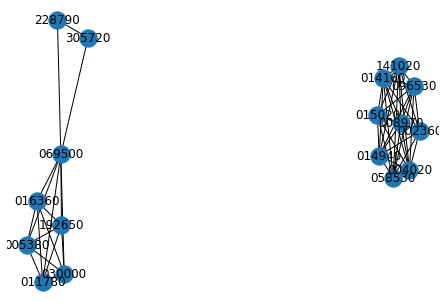

In [ ]:
g = nx.from_pandas_edgelist(a, 'source', 'target', create_using = nx.Graph())
nx.draw(g, with_labels=True)
# print(nx.info(g))
dgr = nx.degree_centrality(g)        # 연결 중심성
btw = nx.betweenness_centrality(g)   # 매개 중심성
cls = nx.closeness_centrality(g)     # 근접 중심성
egv = nx.eigenvector_centrality(g)   # 고유벡터 중심성
pgr = nx.pagerank(g)                 # 페이지 랭크

sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)
sorted_egv = sorted(egv.items(), key=operator.itemgetter(1), reverse=True)
sorted_pgr = sorted(pgr.items(), key=operator.itemgetter(1), reverse=True)

G = nx.Graph()

for i in range(len(sorted_dgr)):
    G.add_node(sorted_pgr[i][0], nodesize=sorted_dgr[i][1])

# for ind in range((len(np.where(dataset['freq'] > 20000)[0]))):
#     G.add_weighted_edges_from([(dataset['word1'][ind], dataset['word2'][ind], int(dataset['freq'][ind]))])

# 노드 크기 조정
sizes = [G.nodes[node]['nodesize'] * 500 for node in G]

options = {
    'edge_color': '#FFDEA2',
    'width': 1,
    'with_labels': True,
    'font_weight': 'regular',
}



In [ ]:


# plt.figure(figsize=(20, 20))
# pos = nx.spring_layout(g, k = 0.15)
# nx.draw_networkx(g,pos, node_size = 25, node_color = 'blue')
# plt.show()